# SciKit-GStat: A scipy flavored geostatistical toolbox written in Python

## EGU 2020 showcase by Mirko Mälicke

In [24]:
import pandas as pd
import numpy as np
import skgstat as skg
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings('ignore')

### 1. Variogram - Kriging

The main objective of `scikit-gstat` is to perform a variogram analysis. It can help you to create a spatial model of your data. This model can then be used to interpolate between the observations.

In [2]:
data = pd.read_csv('./sample_sr.csv')
data.head()

,x,y,z
0,94,20,-0.394444
1,82,37,-2.283663
2,43,13,-0.546213
3,78,42,-3.681384
4,50,28,0.504538


In [11]:
ob = go.Scatter(
    x=data.x,
    y=data.y,
    mode='markers',
    marker=dict(
        size=10, 
        color=data.z, 
        colorscale='Sunsetdark', 
        showscale=True
    ),
    text=['Value: %.2f' % _ for _ in data.z]
)

observations = go.Figure(
    data=ob, 
    layout=dict(
        width=600, 
        height=600,
        template='simple_white'
    )
)

In [12]:
iplot(observations)

The main interface is the `skgstat.Variogram` class. It needs at least a n-D array of coordinates, and a 1D array of values of same length. It will calculate an experimental variogram and fit a model function to it using default parameters. Most behavior can be changed using class arguments. These can be set at instantiation, or adjusted at any later point in time.

Using the built-in `Variogram.plot` function makes variogram analysis an iterative, easy and fun work!

`Variogram.describe` will return fitted variogram model parameters.

In [5]:
print(skg.Variogram.__init__.__doc__)

Variogram Class

        Note: The directional variogram estimation is not re-implemented yet.
        Therefore the parameters is-directional, azimuth and tolerance will
        be ignored at the moment and can be subject to changes.

        Parameters
        ----------
        coordinates : numpy.ndarray
            Array of shape (m, n). Will be used as m observation points of
            n-dimensions. This variogram can be calculated on 1 - n
            dimensional coordinates. In case a 1-dimensional array is passed,
            a second array of same length containing only zeros will be
            stacked to the passed one.
        values : numpy.ndarray
            Array of values observed at the given coordinates. The length of
            the values array has to match the m dimension of the coordinates
            array. Will be used to calculate the dependent variable of the
            variogram.
        estimator : str, callable
            String identifying the semi-v

{'name': 'spherical',
 'estimator': 'matheron',
 'effective_range': 45.96433514431936,
 'sill': 1.2261080176502477,
 'nugget': 0}

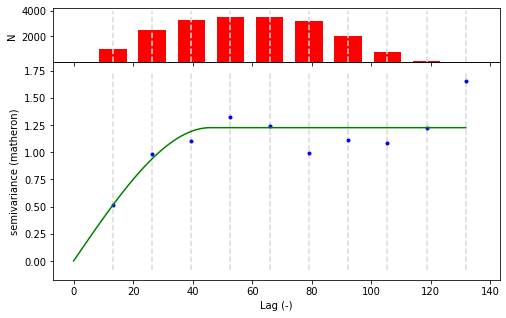

In [35]:
# with default attributes
V = skg.Variogram(data[['x', 'y']].values, data.z.values)
V.plot()
V.describe()

We can limit the distance up to which point pairs are formed using `Variogram.maxlag`. It takes:

- a value $0 < maxlag < 1$ to set `maxlag` to that proportion of the maximum distance
- a value $ > 1$ to explicitly set the maximum distance
- to `'mean' or 'median'` to use the mean or median of all pair-wise distances

Note: `0.5` and `'median'` are not the same! `0.5` is half the *maximum distance*.

{'name': 'spherical',
 'estimator': 'matheron',
 'effective_range': 40.14392370185206,
 'sill': 1.2490431769172805,
 'nugget': 0}

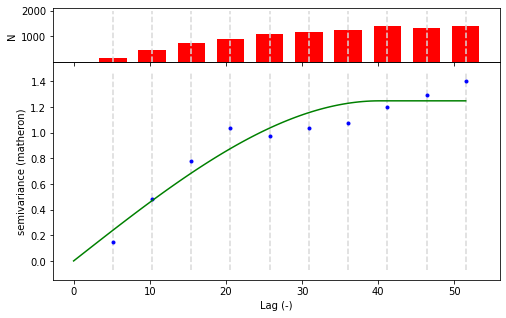

In [36]:
V.maxlag = 'median'
V.plot()
V.describe()

To interpolate the observation using this Variogram, we can simply pass it to the `skgtat.OrdinaryKriging` class. SciKit-GStat implements only Ordinary Kriging as an interpolation method. There is another package: pykrige. it has way more posibilities to perform Kriging. There is an interface function to turn a SciKit-GStat variogram into the parameters needed for pykrige. More on this can be found in the documentation with the next release.

`OrdinaryKriging.transform` then takes an array of unobserved coordinates to predict. 

In [8]:
# create a grid to predict
xx, yy = np.mgrid[0:100:50j, 0:100:50j]

ok = skg.OrdinaryKriging(V)

field = ok.transform(xx.flatten(), yy.flatten())

In [9]:
# prediction
pred = go.Heatmap(z=field, x=xx.flatten(), y=yy.flatten(), colorscale='Sunsetdark', name='Kriging')
obs = go.Scatter(
    x=data.x, 
    y=data.y, 
    mode='markers', 
    marker=dict(size=8, color='black'),
    text=['Value: %.2f' % _ for _ in data.z],
    name='Observation',
)

# figure
prediction = go.Figure(
    layout=dict(
        width=800, 
        height=800,
        template='simple_white',
        xaxis=dict(range=[0,100]),
        yaxis=dict(range=[0,100])
    )
)

In [10]:
prediction.add_trace(pred)
prediction.add_trace(obs)

### 2. Fitting a theoretical function

The second part is mostly about fitting a theoretical function to an experimental variogram. Please also refer to the resources from the documentation, that are related:

* [Tutorial about theoretical functions](https://mmaelicke.github.io/scikit-gstat/tutorials/02_variogram_models.html)
* [Tutorial about semi-variance estimators](https://mmaelicke.github.io/scikit-gstat/tutorials/03_estimators.html)
* [Technical note about fitting](https://mmaelicke.github.io/scikit-gstat/technical/fitting.html)

`skgstat.Variogram` has various possibilities to adjust the fitting procedures. These include:

* `Variogram.estimator` to set the estimator
* `Variogram.model` to set the theoretical variogram model
* `Variogram_fit_method` to change the fitting procedure
* `Variogram.fit_sigma` to change the way experimental values are weighted

All are implemented as properties, which means you can pass `str` values to select pre-defined values and functions. `estimator`, `model` and `fit_sigma` accept beyond that custom functions and values.

The first, maybe most important attribute is the model. We can esily switch to a gaussian model. At the same time, we can learn, how the plotting function can render into a custom figure canvas:

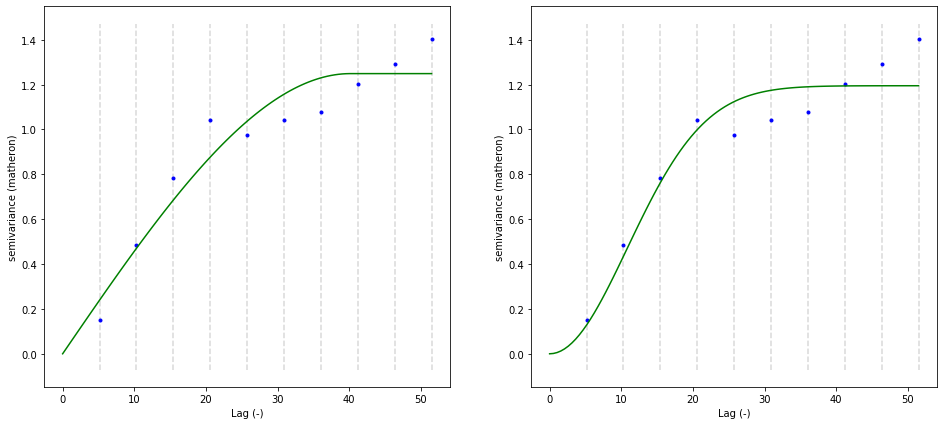

In [37]:
# build a figure
fig, axes = plt.subplots(1,2,figsize=(16,6))

# plot - change model - plot again
V.plot(axes=axes[0], hist=False)
V.model = 'gaussian'
V.plot(axes=axes[1], hist=False);

The same procedure can be used to switch e.g. to the Dowd estimator:

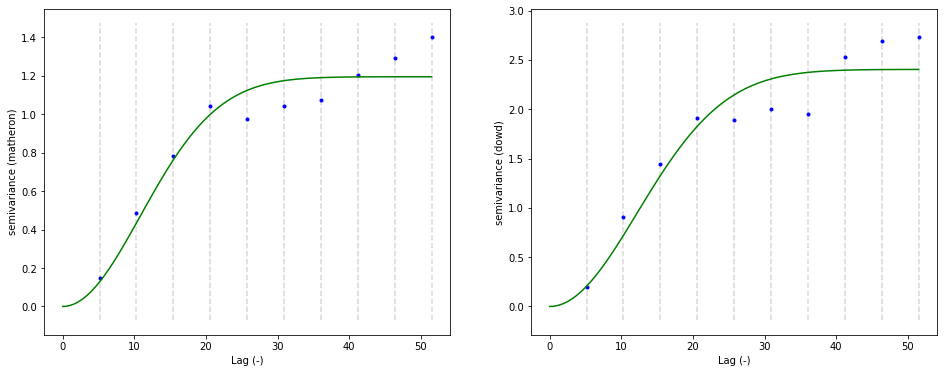

In [40]:
# build a figure
fig, axes = plt.subplots(1,2,figsize=(16,6))

# plot - change model - plot again
V.plot(axes=axes[0], hist=False)
V.estimator = 'dowd'
V.plot(axes=axes[1], hist=False);

Models and estimators are well documented, in the documentation, but also in the function itself:

In [41]:
print(V.estimator.__doc__)
print(V.model.__doc__)

Dowd semi-variance

    Calculates the Dowd semi-variance from an array of pairwise
    differences. Returns the semi-variance for the whole array. In case a
    semi-variance is needed for multiple groups, this function has to be
    mapped on each group. That is the typical use case in geostatistics.

    Parameters
    ----------
    x : numpy.ndarray
        Array of pairwise differences. These values should be the distances
        between pairwise observations in value space. If xi and x[i+h] fall
        into the h separating distance class, x should contain abs(xi - x[i+h])
        as an element.

    Returns
    -------
    numpy.float64

    Notes
    -----
    The Dowd estimator is based on the median of all pairwise differences in
    each lag class and is therefore robust to exteme values at the cost of
    variability.
    This implementation follows Dowd's publication [4]_:

    .. math::

        2\gamma (h) = 2.198 * {median(x)}^2

    with:

    .. math::
        x = 